
#A python script to create an automated roll call for a Shelter in Place emergency. It uses an interactive Excel workbook to accomplish this.

This script was originally made for use by a large chemical company. It was built to scrape the badge logs from a SaaS website the company used. It then used Excel to generate an accountability report. It now only takes 1 person ~5 minutes to complete the report - as opposed to a team of people doing it manually for 30+ minutes.

>Note: The script has been modified from its fully working version to remove any confidential information. It does not have the ability to webdrive, or save to a network folder. This notebook (built in Google Colab) has all of the commented out code removed. The notebook was created to provide a visualization of how the code works. View the .py file to see all code. The .py file is a functioning demo when used with the provided Excel file.

>The provided Excel workbook has been populated with dummy data, since the web scraping and network file portions of the code are not usable without Company access.

#Installing and importing the necessary python packages.

In [ ]:
!pip install xlwings --quiet
import xlwings as xw
import pandas as pd
import re
import numpy as np
#import win32com.client as win32
#from selenium import webdriver
#from selenium.webdriver.common.keys import Keys
#from selenium.webdriver.support.ui import Select
import time
from datetime import timedelta
import sys
import requests
import json
#from requests_negotiate_sspi import HttpNegotiateAuth
#from win32com.client import Dispatch

#Adding time of the emergency to the StartHere sheet.



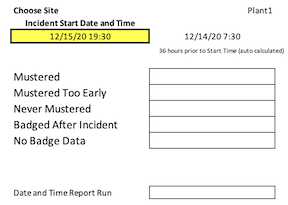

#Declaring each sheet in the notebook that will be used.

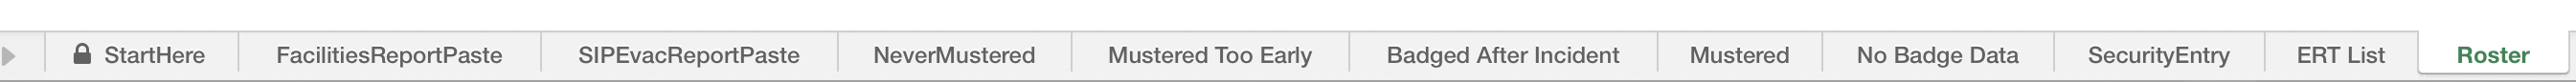

In [ ]:
xw.Book('Evac_Report_Toolvec.xlsm').set_mock_caller()
wb = xw.Book.caller()
wbs = wb.sheets['StartHere']
wbf = wb.sheets['FacilitiesReportPaste']
wbsh = wb.sheets['SIPEvacReportPaste']
wbnm = wb.sheets['NeverMustered']
wbai = wb.sheets['Badged After Incident']
wbmu = wb.sheets['Mustered']
wbmue = wb.sheets['Mustered Too Early']
wbnbd = wb.sheets['No Badge Data']
wbsec = wb.sheets['SecurityEntry']
wbert = wb.sheets['ERT List']
wbr = wb.sheets['Roster']

#Create dataframes of facility report ('fac') and shelter in place ('sip) report sheets.

-Facilities Report: People that have used badge reader at an entry point at the site. Essentially it says they are present.

-SIP Evac Report: People that have used used a badge reader at an emergency shelter or an evac/muster point. This says that they have checked-in at a safe place. In emergency terminology, they have been "accounted for."

Scripting Notes:
> current_region selects all cells on the page.drop[2] removes a "ID Photo" column that is not used.

> .iloc[2:] removes the first two rows. These are pasted values that are not necessary.

>THERE IS FOR SURE A BETTER WAY TO DO THIS!


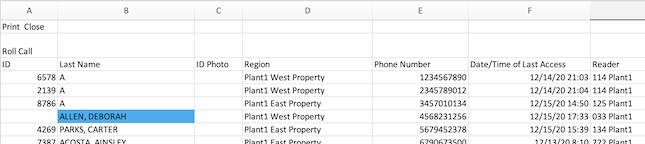

In [ ]:
facdf = pd.DataFrame(wbf.range('A3').current_region.options(numbers = int).value).drop([2],axis =1).iloc[2:]
headsdf = facdf.iloc[0] #Creating headers for all of the dataframes and tabs using the first row.
facdf = facdf[1:] #removes the redundant header row from the dataframe.
facdf.columns = headsdf #setting the column names based on the extracted headers.
facdf = facdf[facdf['Last Name'].str.len() > 3] #Removing any names that are less than 3 characters. Junk entries sometimes show up.
facdf = facdf[facdf["Region"].notnull()].sort_values(by='Last Name') #sorting by last name for processing speed and for readability.
facdf["Date/Time of Last Access"] = pd.to_datetime(facdf["Date/Time of Last Access"], format = '%-m/-%d/%y %-I:%M', errors = 'coerce') #Forcing pandas to read this as a datetime.

In [ ]:
sipdf = pd.DataFrame(wbsh.range('A3').current_region.options(numbers = int).value).drop([2],axis =1).iloc[2:]
sipdf = sipdf[1:]
sipdf.columns = headsdf
sipdf = sipdf[sipdf['Last Name'].str.len() > 3]
sipdf = sipdf[sipdf["Region"].notnull()].sort_values(by='Last Name')
sipdf["Date/Time of Last Access"] = pd.to_datetime(sipdf["Date/Time of Last Access"], format = '%-m/-%d/%y %-I:%M', errors = 'coerce')

#Declaring the timestamps that will be used to determine if the

#Create a "Status" column for each dataframe with the condition of each row.

It needs to be determined how valid the badge access data is. It could be a "ghost" read that should have been cleared out. It could be that the person tapped a reader at an evac point well before the emergency; therefore, they shouldn't be marked as "safe" without confirmation. Or something such as they came to the site after the emergency alarm went off, so they didn't know it happened.

>Originally this status generation was done by having formulas in Excel, but that has been switched to letting Python do the work instead. (Pictured is the formula version to illustrate what the code is doing).

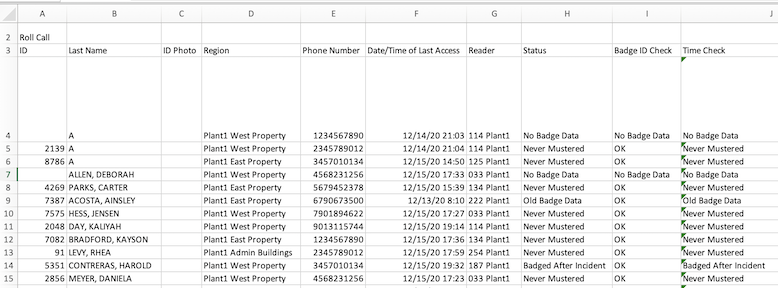

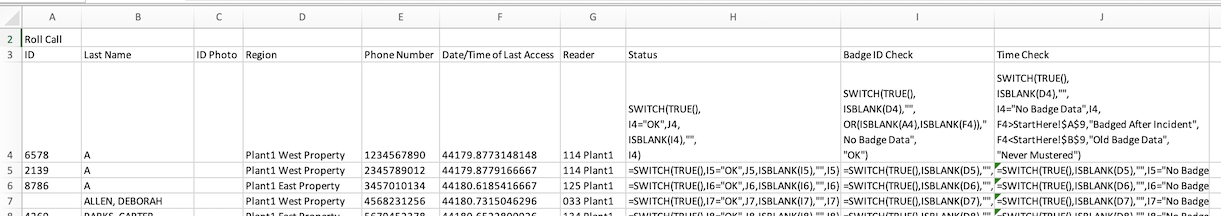

In [ ]:
starttime = pd.to_datetime(wbs.range('A9').value) #Start time of the emergency.
oldtime = pd.to_datetime(wbs.range('B9').value) #The last time in the past before the emergency that badge access data should be considered valid.

conds = [ #conditions are evaluated in order
    facdf['ID'].isna() | facdf['Date/Time of Last Access'].isna(), #No badge ID or last time badge used data.
    facdf['Date/Time of Last Access'] > starttime, #If they came on site after the emergency, but haven't mustered. They may not have heard the alarm.
    facdf['Date/Time of Last Access'] < oldtime, #If the last time they badged indicates the data is old and they are not actually on site.
]
choices = [ #matches condition to what will be added to the column.
    'No Badge Data',
    'Badged After Incident',
    'Old Badge Data'
]
facdf['Status'] = np.select(conds, choices, default='Never Mustered') #These are the people that Emergency Response should be looking for.

In [ ]:
conds = [
    sipdf['ID'].isna() | sipdf['Date/Time of Last Access'].isna(), #No badge ID or last time badge used data.
    sipdf['Date/Time of Last Access'] > starttime #Mark as safe as they have checked in at a muster reader.
]
choices = [
    'No Badge Data',
    'Mustered'
]
sipdf['Status'] = np.select(conds, choices, default='Mustered Too Early') #Scanned a muster reader before an emergency. Usually because they were anticipating a drill.

#Creating dataframes of each category/condition of the badge read.

In [ ]:
nmdf = facdf.loc[facdf.Status == "Never Mustered"].drop('Status', axis = 1) #never mustered dataframe
aidf = facdf.loc[facdf.Status == "Badged After Incident"].drop('Status', axis = 1) #badged after incident
nbdf = facdf.loc[facdf.Status == "No Badge Data"].drop('Status', axis = 1) #no badge data in unmustered report

ncount = len(nmdf) #counting number of people that did not muster.
aicount = len(aidf) #Counting the number of people that badged into the site after the emergency, and haven't mustered.

try: #Doing error handling if reporting tool is run without anybody sheltering
    mdf = sipdf.loc[sipdf.Status == "Mustered"].drop('Status', axis = 1) #mustered dataframe
    mtdf = sipdf.loc[sipdf.Status == "Mustered Too Early"].drop('Status', axis = 1) #mustered before incident time
    nbdf2 = sipdf.loc[sipdf.Status == "No Badge Data"].drop('Status', axis = 1) #no badge data in SIP report
    nbdf = pd.concat([nbdf,nbdf2]) #combining no badge data
    mcount = len(mdf) #Counting number of people that mustered.
    mtcount = len(mtdf) #Counting number of people that mustered too early.
except:
    mdf = None
    mtdf = None
    mcount = 0
    mtcount = 0

nbdcount = len(nbdf) #Counting number of people in category

#Matching visitors (registered at plant Security) on site to never mustered, mustered early, or badged after incident.

Otherwise the SaaS pull would just show a visitor number.

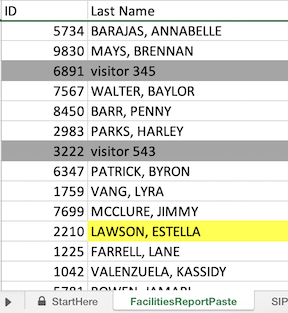

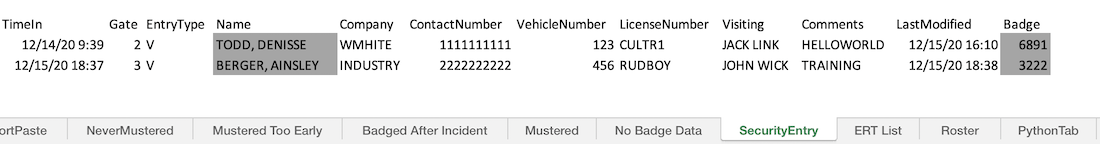

In [ ]:
try:
    secdf = pd.DataFrame(wbsec.range('A1').current_region.options(numbers = int).value) #The security log data sheet.
    headsdf = secdf.iloc[0] #Creating header for the dataframe using the first row.
    secdf = secdf[1:] #removes the redundant header row from the dataframe.
    secdf.columns = headsdf #setting the column names based on the extracted headers.

    secdf['Badge'] = secdf['Badge'].astype(str).str.strip()
    secdf['ContactNumber'] = secdf['ContactNumber'].astype(str).str.strip()
    secdf['Name'] = secdf['Name'].astype(str).str.strip()
    secdf = secdf.drop_duplicates(subset='Badge', keep='first')

    print('Attempting to match unaccounted visitor badges to phone numbers')
    badgeid_to_phone = secdf.set_index('Badge')['ContactNumber'].to_dict()
    badgeid_to_name  = secdf.set_index('Badge')['Name'].to_dict()

    pd.set_option('future.no_silent_downcasting', True) #Fixes a deprecation error I encountered.

    def replace_from_seclog(df):
        dfid = df['ID'].astype(str).str.strip()
        df['Phone Number'] = dfid.map(badgeid_to_phone).fillna(df['Phone Number'])
        df['Last Name'] = dfid.map(badgeid_to_name).fillna(df['Last Name'])
        return df

    # apply to your frames
    nmdf = replace_from_seclog(nmdf)
    mtdf = replace_from_seclog(mtdf)
    aidf = replace_from_seclog(aidf)
except:
    print("Either there were no Security/Truck entries or there was an error. Please check PlantView.")
    pass

Completed matches:

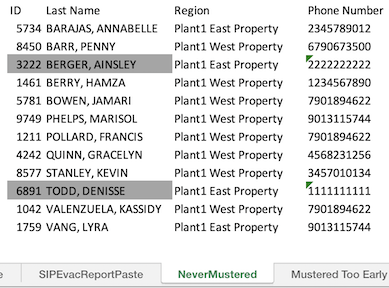

#Checking ERT Roster to find names of members that are on site.

A member of the site's Emergency Response Team may not have used a shelter reader...because they were responding to the emergency. They'll still show up as on site though.

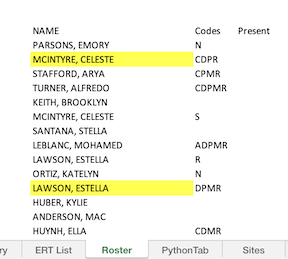

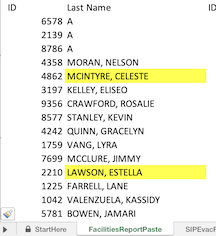

In [ ]:
print("Checking ERT Roster to find names of members that are on site, but not sheltered")
try:
    #Creating dataframe for roster. Dummy data is already in the sheet
    perdf = pd.DataFrame(wbr.range('A1').expand().value)
    perdf.columns = ['Name','Codes','Present']
    perdf['Name']=perdf['Name'].str.upper()

    #Searching roll calls for ERT members on site
    for line, row in enumerate(facdf.itertuples(),1):
        regex = re.compile(row[2], re.IGNORECASE)
        matched = [x for x in perdf['Name'].values if regex.match(x)]
        if matched == []:
            continue
        else:
            facdf.at[row.Index, 'Present'] = "Yes"
            facdf.at[row.Index, 'Roster Name'] = perdf.loc[perdf.Name == matched[0], 'Name'].values[0]

    #Creating dataframe of on site ERT members
    ertdf = facdf.loc[facdf.Present == "Yes"]
    ertdf = ertdf.loc[:,['Roster Name']]
    ertdf = ertdf.drop_duplicates(subset = 'Roster Name')
    wbert.range('A1').options(index=False, header=True).value = ertdf.sort_values(by="Roster Name")
except:
    print("Something went wrong with getting the ERT roster. Skipping")
    pass

This list makes it easier to confirm responders with the ERT Chief.

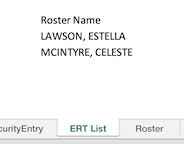

#Populating the Excel sheets with all of the dataframes.

Because dataframes really only live in the code 🙂

In [ ]:
wbnm.range('A1').options(index=False, header=True).value = nmdf.sort_values(by = 'Last Name')
wbai.range('A1').options(index=False, header=True).value = aidf.sort_values(by = 'Last Name')
wbmu.range('A1').options(index=False, header=True).value = mdf.sort_values(by = 'Last Name')
wbmue.range('A1').options(index=False, header=True).value = mtdf.sort_values(by = 'Last Name')
wbnbd.range('A1').options(index=False, header=True).value = nbdf.sort_values(by = 'Last Name')

#Format column width
wbnm.autofit()
wbai.autofit()
wbmu.autofit()
wbmue.autofit()
wbnbd.autofit()
wbsec.autofit()
wbert.autofit()

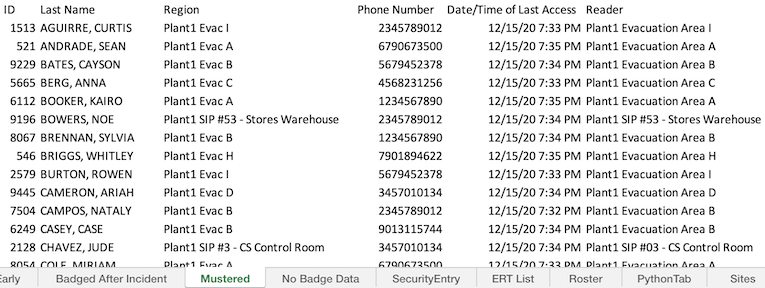

#Populating a summary on the StartHere sheet.
A summary makes it easy to report out the numbers.

In [ ]:
wbs.range('B12').options(transpose=True).value = mcount, mtcount, ncount, aicount, nbdcount #Adding counts of each category to main page.
wbs.range('B20').value = time.strftime("%m/%d/%Y %H:%M") #Adding a timestamp of when the report was run.

In this example, the Emergency Management Team knows they have 60 people that they can deem as safe. They have 38 more that they need to investigate.

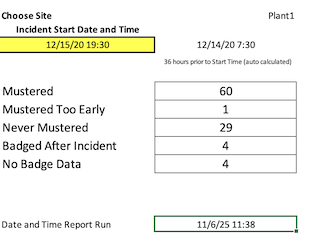